<a href="https://colab.research.google.com/github/blindauth/abstention_experiments/blob/master/convergence_experiments/CohensKappaConvergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -r abstention
!pip uninstall abstention
!git clone https://github.com/blindauth/abstention.git
!pip install abstention/

rm: cannot remove 'abstention': No such file or directory
Cloning into 'abstention'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 51 (delta 18), reused 42 (delta 9), pack-reused 0
Unpacking objects: 100% (51/51), done.
Processing ./abstention
  Stored in directory: /tmp/pip-ephem-wheel-cache-wiqt6ro0/wheels/60/8e/d2/9e9ca02e7b5f76bfda2e2daa6dcbe42c19095c502ccb653729
Successfully built abstention


In [0]:
import numpy as np
import scipy.stats

#simulate some data
def generate_dataset(n, class_proportions,
                        class_means,
                        class_stds, seed=1234):
    assert len(class_proportions)==len(class_means)
    assert len(class_proportions)==len(class_stds)
    
    rng = np.random.RandomState(seed)
    labels = []
    predicted_outputs = []
    calibrated_probs = []
    
    for label in rng.multinomial(n=1, pvals=class_proportions, size=n):
        labels.append(label)
        sampled_class = np.argmax(label)
        
        output = class_stds[sampled_class]*(
            rng.randn(1)[0]) + class_means[sampled_class]
        predicted_outputs.append(output)

        this_calibrated_probs = np.zeros(len(class_proportions))
        for class_idx in range(len(class_proportions)):
          this_calibrated_probs[class_idx] =(
            scipy.stats.norm.pdf(
              output,class_means[class_idx],class_stds[class_idx])
            *class_proportions[class_idx])
        this_calibrated_probs = this_calibrated_probs/np.sum(
                                  this_calibrated_probs)
        calibrated_probs.append(this_calibrated_probs)    
    return np.array(labels), np.array(predicted_outputs), np.array(calibrated_probs)
  

In [0]:
labels, pred_outputs, calib_probs = generate_dataset(
    n=10000,
    class_proportions=[0.4, 0.3, 0.2, 0.1],
    class_means=[-8, -3, 3, 4],
    class_stds = [4, 3, 3, 2])

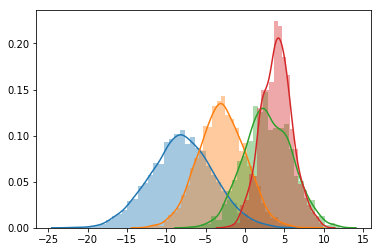

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.distplot(pred_outputs[labels[:,0]==1])
sns.distplot(pred_outputs[labels[:,1]==1])
sns.distplot(pred_outputs[labels[:,2]==1])
sns.distplot(pred_outputs[labels[:,3]==1])
plt.show()

In [5]:
from abstention.abstention import weighted_kappa_metric

quadratic_weights = np.array([[(i-j)**2 for i in range(4)]
                               for j in range(4)])
print(weighted_kappa_metric(predprobs=calib_probs,
                            true_labels=labels,
                            weights=quadratic_weights,
                            #'mode' determines how the predicted class
                            # is selected - we use the standard way of
                            # determining the predicted class, which is to
                            # take the argmax over the class probabilities
                            mode='argmax'))

0.7754523560064345


In [6]:
import scipy.signal
from abstention.abstention import (
    RecursiveEstMarginalWeightedKappa,
    EstMarginalWeightedKappa, MonteCarloMarginalWeightedKappa,
    OneMinusJSDivFromClassFreq)

abstention_scores_jsdiv = OneMinusJSDivFromClassFreq()()(
                            posterior_probs=calib_probs)

abstention_scores_estmarginalweightedkappa = EstMarginalWeightedKappa(
  weights=quadratic_weights, mode='argmax')()(posterior_probs=calib_probs)

abstention_scores_montecarlomarginalweightedkappa_100samp =\
  MonteCarloMarginalWeightedKappa(
    weights=quadratic_weights,
    mode='argmax', n_samples=100, seed=1234)()(posterior_probs=calib_probs)

#abstention_scores_recursiveestmarginalweightedkappa =\
#  RecursiveEstMarginalWeightedKappa(
#    weights=quadratic_weights, mode='argmax',
#    num_abstained_per_iter=[int(0.05*len(calib_probs))]*5
#    )()(posterior_probs=calib_probs)

for abstention_pc in [0.3, 0.2, 0.1, 0.05]:
  print("abstention percent", abstention_pc)
  for abstention_scores in [abstention_scores_jsdiv,
                            abstention_scores_estmarginalweightedkappa,
                            abstention_scores_montecarlomarginalweightedkappa_100samp]:
      retained_indices = [x[0] for x in sorted(
          enumerate(abstention_scores),
          key=lambda x: x[1])[:-int(abstention_pc*len(abstention_scores))]]
      retained_calib_probs = calib_probs[retained_indices]
      retained_labels = labels[retained_indices]
      
      print(weighted_kappa_metric(
            predprobs=retained_calib_probs,
            true_labels=retained_labels,
            weights=quadratic_weights,
            mode='argmax'))
      


abstention percent 0.3
0.8443642510148147
0.8473256980764523
0.847624715447574
abstention percent 0.2
0.8230227179387415
0.8270685243378594
0.8249733092325326
abstention percent 0.1
0.8012058035692182
0.8044066005780167
0.8029122693656979
abstention percent 0.05
0.7884220944167324
0.7915008721019239
0.7897874913150008


In [7]:

abstention_scores_estmarginalweightedkappa = EstMarginalWeightedKappa(
  weights=quadratic_weights, mode='argmax')()(posterior_probs=calib_probs)

n_samples = 50
num_iters = 20

mcfunc = MonteCarloMarginalWeightedKappa(
    weights=quadratic_weights,
    mode='argmax', n_samples=n_samples, seed=1234)()

the_mean = np.zeros(len(calib_probs))

difference_from_est = []

for i in range(0,num_iters):
    abstention_scores =\
      mcfunc(posterior_probs=calib_probs)
    the_mean = (the_mean*i + abstention_scores)/(i+1)
    avg_diff = np.mean(np.abs(abstention_scores_estmarginalweightedkappa
                         -the_mean) )
    print("Samples",n_samples*(i+1),
          "mean difference", avg_diff)
    difference_from_est.append(avg_diff)

Samples 50 mean difference 3.2128149473350618e-06
Samples 100 mean difference 2.275837083083059e-06
Samples 150 mean difference 1.8756552778137638e-06
Samples 200 mean difference 1.6296483811096983e-06
Samples 250 mean difference 1.4593070638135072e-06
Samples 300 mean difference 1.3385715885727603e-06
Samples 350 mean difference 1.2312388465524866e-06
Samples 400 mean difference 1.148836009342058e-06
Samples 450 mean difference 1.0816118399891126e-06
Samples 500 mean difference 1.0199306544690796e-06
Samples 550 mean difference 9.780265232484366e-07
Samples 600 mean difference 9.355898520167605e-07
Samples 650 mean difference 8.999954185881532e-07
Samples 700 mean difference 8.631974625477497e-07
Samples 750 mean difference 8.302469014791186e-07
Samples 800 mean difference 8.033476781880532e-07
Samples 850 mean difference 7.782472917853038e-07
Samples 900 mean difference 7.560046783586367e-07
Samples 950 mean difference 7.378232050586909e-07
Samples 1000 mean difference 7.184932264103

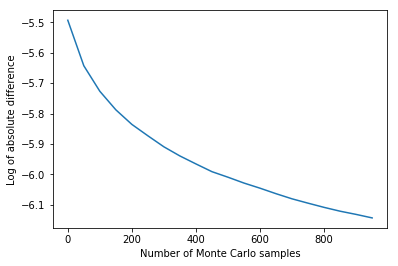

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.arange(num_iters)*n_samples, np.log(difference_from_est)/np.log(10))
plt.xlabel("Number of Monte Carlo samples")
plt.ylabel("Log of absolute difference")
plt.show()